## Henok Desalegn

## Task 1: Import Important Libraries

In [3]:
# Import packages

import pandas as pd
import numpy as np
import random
import nltk
import ccxt
import ta
import datetime
#notebook reproducible 
np.random.seed(42)
random.seed(42)

# preprocessing and feature engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# modeling
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from pandas_profiling import ProfileReport
# from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# rcParams['figure.figsize'] = 22, 10

C:\Users\hp\AppData\Local\Temp\ipykernel_26080\1863039164.py:34: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [4]:
# importing script modules from ../scripts
# Adding scripts path
import sys, os
sys.path.insert(0, '../scripts/')

from trade_old import Trading, Trader
from trader_model import LSTMModel
from DataPreprocessor import DataPreprocessor

In [3]:
trader1 = Trader('AAPL', 100, 150)


TypeError: __init__() takes 3 positional arguments but 4 were given

In [7]:
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeFrame = '1d'
limit = 3500

# create an instance of the Trading class
trading = Trading(exchange=exchange, symbol='BTC/USDT', timeFrame='5m', limit=1000)

# fetch historical data
trading.get_data(from_date='2022-07-21 00:00:00')

# print the DataFrame
print(trading.df.head())


       timestamp      open      high       low     close     volume  \
0  1658361600000  23223.30  23313.21  23200.00  23295.74  810.02499   
1  1658361900000  23295.74  23317.78  23253.39  23290.75  596.20078   
2  1658362200000  23288.89  23350.00  23263.66  23318.27  622.86222   
3  1658362500000  23320.68  23386.56  23307.91  23351.12  639.88214   
4  1658362800000  23352.31  23358.81  23271.40  23317.21  472.22990   

                 time  day_of_week  hour_of_day  sma15  sma60   rsi  
0 2022-07-21 00:00:00            3            0    NaN    NaN  None  
1 2022-07-21 00:05:00            3            0    NaN    NaN  None  
2 2022-07-21 00:10:00            3            0    NaN    NaN  None  
3 2022-07-21 00:15:00            3            0    NaN    NaN  None  
4 2022-07-21 00:20:00            3            0    NaN    NaN  None  


In [9]:
df = trading.df

len(df)

65791

In [5]:
df.to_csv('../data/Trade_sentiment.csv', index=False, header=True)

## Task 2: Data Ingestion (Load) and Inspection

In [5]:
df = pd.read_csv('../data/Trade_sentiment.csv', parse_dates=['timestamp'])
print(f"The dataset contains {len(df)} Trading Sentiments")
pd.set_option('display.max_columns', len(df.columns)) # To view all columns , , index_col='Date'
pd.set_option('display.max_rows', 100)
df.head(3)

The dataset contains 65791 Trading Sentiments


timestamp      open      high       low     close     volume  \
0  1658361600000  23223.30  23313.21  23200.00  23295.74  810.02499   
1  1658361900000  23295.74  23317.78  23253.39  23290.75  596.20078   
2  1658362200000  23288.89  23350.00  23263.66  23318.27  622.86222   

                  time  day_of_week  hour_of_day  sma15  sma60  rsi  
0  2022-07-21 00:00:00            3            0    NaN    NaN  NaN  
1  2022-07-21 00:05:00            3            0    NaN    NaN  NaN  
2  2022-07-21 00:10:00            3            0    NaN    NaN  NaN

In [6]:
preprocessor = DataPreprocessor(df)
preprocessor.preprocess()

# Access the preprocessed data
X_train = preprocessor.train['X']
y_train = preprocessor.train['y']
X_val = preprocessor.val['X']
y_val = preprocessor.val['y']
X_test = preprocessor.test['X']
y_test = preprocessor.test['y']


In [12]:
X_test.shape, y_test.shape

((9839, 30, 3), (9839,))

In [11]:
prof_listings = ProfileReport(df) 
# prof_listings

In [71]:
df.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
df.head(2)

timestamp     open     high      low    close        volume  \
0  1591660800000  9782.00  9877.00  9570.00  9772.43  46024.001289   
1  1591747200000  9772.44  9992.72  9704.18  9885.00  47130.762982   

         time  sma15  sma60  rsi  
0  2020-06-09    NaN    NaN  NaN  
1  2020-06-10    NaN    NaN  NaN

In [9]:
df.shape

(65791, 12)

In [10]:
df.dtypes


timestamp       object
open           float64
high           float64
low            float64
close          float64
volume         float64
time            object
day_of_week      int64
hour_of_day      int64
sma15          float64
sma60          float64
rsi            float64
dtype: object

In [11]:
df.describe()

open          high           low         close        volume  \
count  65791.000000  65791.000000  65791.000000  65791.000000  65791.000000   
mean   20162.150582  20182.278474  20141.589296  20162.135984    877.324467   
std     2585.952172   2590.478805   2581.012912   2585.941260    750.680190   
min    15590.570000  15633.310000  15476.000000  15593.580000     45.095170   
25%    17243.680000  17257.130000  17231.285000  17243.605000    446.757600   
50%    20052.210000  20078.580000  20030.000000  20052.210000    666.313910   
75%    22738.130000  22761.450000  22710.140000  22737.490000   1040.206675   
max    25238.000000  25250.000000  25086.650000  25235.360000  14683.853120   

        day_of_week   hour_of_day         sma15         sma60  rsi  
count  65791.000000  65791.000000  65777.000000  65732.000000  0.0  
mean       3.023696     11.490888  20161.572572  20159.796622  NaN  
std        1.998731      6.925094   2585.425498   2583.937450  NaN  
min        0.000000      0.000000  15708.235333  15726.200667  NaN  
25%        1.000000      5.000000  17243.024000  17236.439792  NaN  
50%        3.000000     11.000000  20050.804000  20048.198000  NaN  
75%        5.000000     17.000000  22736.702667  22743.539292  NaN  
max        6.000000     23.000000  25023.522667  24955.406333  NaN

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65791 entries, 0 to 65790
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    65791 non-null  object 
 1   open         65791 non-null  float64
 2   high         65791 non-null  float64
 3   low          65791 non-null  float64
 4   close        65791 non-null  float64
 5   volume       65791 non-null  float64
 6   time         65791 non-null  object 
 7   day_of_week  65791 non-null  int64  
 8   hour_of_day  65791 non-null  int64  
 9   sma15        65777 non-null  float64
 10  sma60        65732 non-null  float64
 11  rsi          0 non-null      float64
dtypes: float64(8), int64(2), object(2)
memory usage: 6.0+ MB


In [17]:
df.isna().sum()

timestamp          0
open               0
high               0
low                0
close              0
volume             0
time               0
day_of_week        0
hour_of_day        0
sma15             14
sma60             59
rsi            65791
dtype: int64

In [18]:
df_indicators = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)

c:\Users\hp\Trading\trader_env\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\hp\Trading\trader_env\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [19]:
df_indicators

timestamp      open      high       low     close     volume  ...  \
0      1658361600000  23223.30  23313.21  23200.00  23295.74  810.02499  ...   
1      1658361900000  23295.74  23317.78  23253.39  23290.75  596.20078  ...   
2      1658362200000  23288.89  23350.00  23263.66  23318.27  622.86222  ...   
3      1658362500000  23320.68  23386.56  23307.91  23351.12  639.88214  ...   
4      1658362800000  23352.31  23358.81  23271.40  23317.21  472.22990  ...   
...              ...       ...       ...       ...       ...        ...  ...   
65786  1678077900000  22355.71  22362.06  22334.06  22335.61  642.39749  ...   
65787  1678078200000  22336.63  22350.39  22334.07  22343.44  495.94992  ...   
65788  1678078500000  22343.44  22349.19  22339.08  22342.63  291.64743  ...   
65789  1678078800000  22342.63  22348.78  22330.46  22333.35  531.34732  ...   
65790  1678079100000  22332.45  22355.81  22313.94  22346.70  787.07140  ...   

      momentum_pvo_signal  momentum_pvo_hist  momentum_kama  others_dr  \
0                0.000000           0.000000   23295.740000  15.542024   
1               -0.429552          -1.718207   23293.710503  -0.021420   
2               -1.062772          -2.532883   23304.290163   0.118158   
3               -1.760033          -2.789041   23324.345444   0.140877   
4               -2.837149          -4.308463   23321.636050  -0.145218   
...                   ...                ...            ...        ...   
65786          -17.334233           8.625321   22371.334894  -0.094558   
65787          -15.488123           7.384439   22369.318334   0.035056   
65788          -14.568010           3.680454   22367.506124  -0.003625   
65789          -13.461362           4.426591   22360.473023  -0.041535   
65790          -11.459239           8.008493   22358.754179   0.059776   

       others_dlr  others_cr  
0        0.000000   0.000000  
1       -0.021423  -0.021420  
2        0.118089   0.096713  
3        0.140778   0.237726  
4       -0.145323   0.092163  
...           ...        ...  
65786   -0.094602  -4.121483  
65787    0.035050  -4.087872  
65788   -0.003625  -4.091349  
65789   -0.041544  -4.131184  
65790    0.059758  -4.073878  

[65791 rows x 98 columns]

### Sort the dataframe by date on ascending order

In [270]:
'''df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()'''

"df['Date'] = pd.to_datetime(df['Date'])\ndf['Date'].min(), df['Date'].max()"

In [4]:
df.sort_values(by='time', ascending = True, inplace=True)
df.head()

timestamp      open      high       low     close     volume  \
0  1658361600000  23223.30  23313.21  23200.00  23295.74  810.02499   
1  1658361900000  23295.74  23317.78  23253.39  23290.75  596.20078   
2  1658362200000  23288.89  23350.00  23263.66  23318.27  622.86222   
3  1658362500000  23320.68  23386.56  23307.91  23351.12  639.88214   
4  1658362800000  23352.31  23358.81  23271.40  23317.21  472.22990   

                  time  day_of_week  hour_of_day  sma15  sma60  rsi  
0  2022-07-21 00:00:00            3            0    NaN    NaN  NaN  
1  2022-07-21 00:05:00            3            0    NaN    NaN  NaN  
2  2022-07-21 00:10:00            3            0    NaN    NaN  NaN  
3  2022-07-21 00:15:00            3            0    NaN    NaN  NaN  
4  2022-07-21 00:20:00            3            0    NaN    NaN  NaN

### pairwise correlation

In [5]:
df_plot = df.drop(['time'], axis = 1)

In [24]:
df_plot

timestamp      open      high       low     close     volume  \
0      1658361600000  23223.30  23313.21  23200.00  23295.74  810.02499   
1      1658361900000  23295.74  23317.78  23253.39  23290.75  596.20078   
2      1658362200000  23288.89  23350.00  23263.66  23318.27  622.86222   
3      1658362500000  23320.68  23386.56  23307.91  23351.12  639.88214   
4      1658362800000  23352.31  23358.81  23271.40  23317.21  472.22990   
...              ...       ...       ...       ...       ...        ...   
65786  1678077900000  22355.71  22362.06  22334.06  22335.61  642.39749   
65787  1678078200000  22336.63  22350.39  22334.07  22343.44  495.94992   
65788  1678078500000  22343.44  22349.19  22339.08  22342.63  291.64743   
65789  1678078800000  22342.63  22348.78  22330.46  22333.35  531.34732   
65790  1678079100000  22332.45  22355.81  22313.94  22346.70  787.07140   

       day_of_week  hour_of_day         sma15         sma60  rsi  
0                3            0           NaN           NaN  NaN  
1                3            0           NaN           NaN  NaN  
2                3            0           NaN           NaN  NaN  
3                3            0           NaN           NaN  NaN  
4                3            0           NaN           NaN  NaN  
...            ...          ...           ...           ...  ...  
65786            0            4  22378.051333  22396.688833  NaN  
65787            0            4  22375.002667  22395.176000  NaN  
65788            0            4  22371.254667  22393.715833  NaN  
65789            0            5  22367.476667  22392.011333  NaN  
65790            0            5  22364.365333  22390.631833  NaN  

[65791 rows x 11 columns]

C:\Users\hp\AppData\Local\Temp\ipykernel_15964\575769924.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = df_plot.corr('pearson')


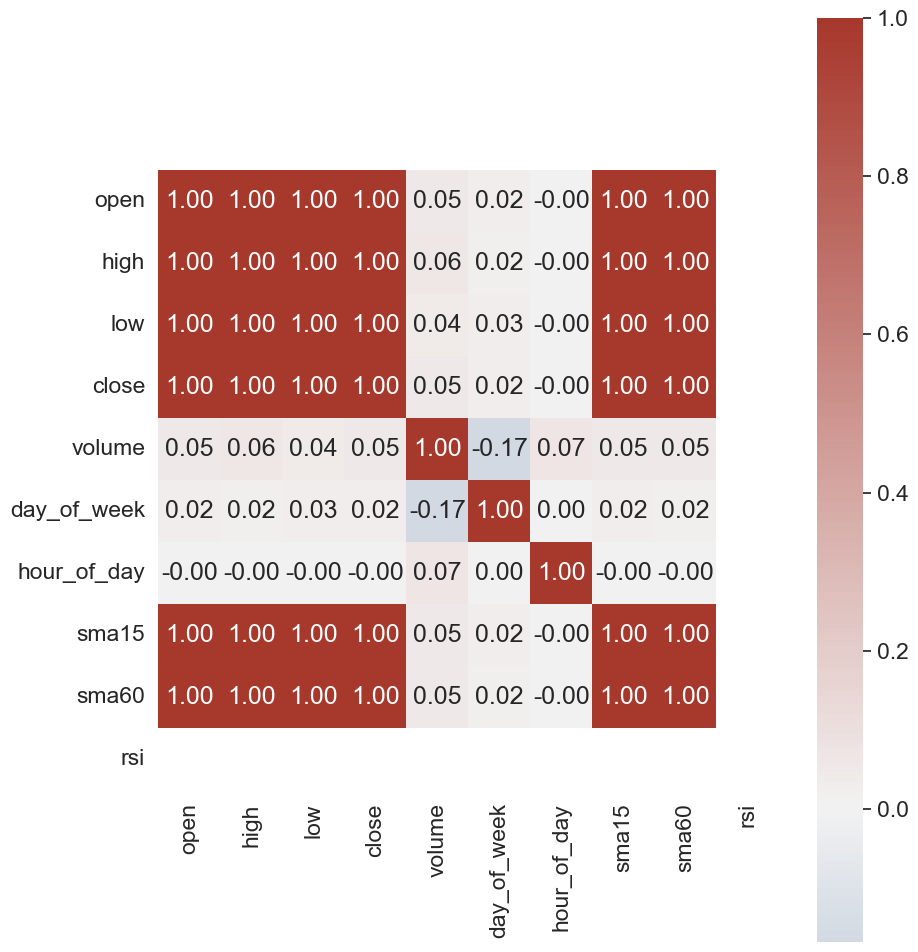

In [25]:
matrix = df_plot.corr('pearson')

plt.figure(figsize=(10,12))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

_ = sns.heatmap(matrix, center=0, annot=True, 
                fmt='.2f', square=True, cmap=cmap)
plt.savefig("../img/pearsonCorrelation.png", bbox_inches='tight')

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.time, y=df.close,
                    mode='lines',
                    name='close price'))
fig.update_layout(showlegend=True)
fig.show()

### Task 3: Data Preprocessing

In [9]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'time',
       'day_of_week', 'hour_of_day', 'sma15', 'sma60', 'rsi'],
      dtype='object')

In [12]:
df_ml = df.drop(['timestamp', 'open', 'high', 'low', 'volume', 'day_of_week', 'hour_of_day', 'rsi'], axis = 1)
df_ml

close                 time         sma15         sma60
0      23295.74  2022-07-21 00:00:00           NaN           NaN
1      23290.75  2022-07-21 00:05:00           NaN           NaN
2      23318.27  2022-07-21 00:10:00           NaN           NaN
3      23351.12  2022-07-21 00:15:00           NaN           NaN
4      23317.21  2022-07-21 00:20:00           NaN           NaN
...         ...                  ...           ...           ...
65786  22335.61  2023-03-06 04:45:00  22378.051333  22396.688833
65787  22343.44  2023-03-06 04:50:00  22375.002667  22395.176000
65788  22342.63  2023-03-06 04:55:00  22371.254667  22393.715833
65789  22333.35  2023-03-06 05:00:00  22367.476667  22392.011333
65790  22346.70  2023-03-06 05:05:00  22364.365333  22390.631833

[65791 rows x 4 columns]

In [13]:
df_ml.isna().sum()

close     0
time      0
sma15    14
sma60    59
dtype: int64

In [14]:
df_ml['close'].fillna(df_ml['close'].mean(), inplace = True)
df_ml['sma15'].fillna(df_ml['sma15'].mean(), inplace = True)
df_ml['sma60'].fillna(df_ml['sma60'].mean(), inplace = True)
df_ml

close                 time         sma15         sma60
0      23295.74  2022-07-21 00:00:00  20161.572572  20159.796622
1      23290.75  2022-07-21 00:05:00  20161.572572  20159.796622
2      23318.27  2022-07-21 00:10:00  20161.572572  20159.796622
3      23351.12  2022-07-21 00:15:00  20161.572572  20159.796622
4      23317.21  2022-07-21 00:20:00  20161.572572  20159.796622
...         ...                  ...           ...           ...
65786  22335.61  2023-03-06 04:45:00  22378.051333  22396.688833
65787  22343.44  2023-03-06 04:50:00  22375.002667  22395.176000
65788  22342.63  2023-03-06 04:55:00  22371.254667  22393.715833
65789  22333.35  2023-03-06 05:00:00  22367.476667  22392.011333
65790  22346.70  2023-03-06 05:05:00  22364.365333  22390.631833

[65791 rows x 4 columns]

In [15]:
df_ml.isna().sum()

close    0
time     0
sma15    0
sma60    0
dtype: int64

## Task 4: Create Training/Test/Val Splits (70/15/15)

In [16]:
# Split the data into train and test sets (85/15 split)
train_val, test = train_test_split(df_ml, test_size=0.15, shuffle=False)

# Split the remaining data into train and validation sets (70/15 split)
train, val = train_test_split(train_val, test_size=0.1765, shuffle=False)

# Print the sizes of the resulting sets
print("Training set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))


Training set size: 46051
Validation set size: 9871
Test set size: 9869


In [17]:
train

close                 time         sma15         sma60
0      23295.74  2022-07-21 00:00:00  20161.572572  20159.796622
1      23290.75  2022-07-21 00:05:00  20161.572572  20159.796622
2      23318.27  2022-07-21 00:10:00  20161.572572  20159.796622
3      23351.12  2022-07-21 00:15:00  20161.572572  20159.796622
4      23317.21  2022-07-21 00:20:00  20161.572572  20159.796622
...         ...                  ...           ...           ...
46046  16757.38  2022-12-27 17:20:00  16776.647333  16802.211667
46047  16752.27  2022-12-27 17:25:00  16774.836667  16800.982500
46048  16752.75  2022-12-27 17:30:00  16773.542000  16799.808333
46049  16746.29  2022-12-27 17:35:00  16771.648667  16798.466667
46050  16664.00  2022-12-27 17:40:00  16763.411333  16795.671833

[46051 rows x 4 columns]

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object and fit it to the training data
scaler = MinMaxScaler()
scaler.fit(train[['close', 'sma15', 'sma60']])

# Apply the scaler to the training, validation, and test sets
train[['close_scaled', 'sma15_scaled', 'sma60_scaled']] = scaler.transform(train[['close', 'sma15', 'sma60']])
val[['close_scaled', 'sma15_scaled', 'sma60_scaled']] = scaler.transform(val[['close', 'sma15', 'sma60']])
test[['close_scaled', 'sma15_scaled', 'sma60_scaled']] = scaler.transform(test[['close', 'sma15', 'sma60']])


In [19]:
train

close                 time         sma15         sma60  \
0      23295.74  2022-07-21 00:00:00  20161.572572  20159.796622   
1      23290.75  2022-07-21 00:05:00  20161.572572  20159.796622   
2      23318.27  2022-07-21 00:10:00  20161.572572  20159.796622   
3      23351.12  2022-07-21 00:15:00  20161.572572  20159.796622   
4      23317.21  2022-07-21 00:20:00  20161.572572  20159.796622   
...         ...                  ...           ...           ...   
46046  16757.38  2022-12-27 17:20:00  16776.647333  16802.211667   
46047  16752.27  2022-12-27 17:25:00  16774.836667  16800.982500   
46048  16752.75  2022-12-27 17:30:00  16773.542000  16799.808333   
46049  16746.29  2022-12-27 17:35:00  16771.648667  16798.466667   
46050  16664.00  2022-12-27 17:40:00  16763.411333  16795.671833   

       close_scaled  sma15_scaled  sma60_scaled  
0          0.806629      0.481823      0.489304  
1          0.806106      0.481823      0.489304  
2          0.808988      0.481823      0.489304  
3          0.812429      0.481823      0.489304  
4          0.808877      0.481823      0.489304  
...             ...           ...           ...  
46046      0.121882      0.115595      0.118751  
46047      0.121347      0.115400      0.118616  
46048      0.121397      0.115259      0.118486  
46049      0.120721      0.115055      0.118338  
46050      0.112103      0.114163      0.118030  

[46051 rows x 7 columns]

In [20]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps), :].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['close_scaled', 'sma15_scaled', 'sma60_scaled']], train['close_scaled'])
X_test, y_test = create_sequences(test[['close_scaled', 'sma15_scaled', 'sma60_scaled']], test['close_scaled'])
X_val, y_val = create_sequences(val[['close_scaled', 'sma15_scaled', 'sma60_scaled']], val['close_scaled'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')
print(f'Validation shape: {X_val.shape}')

print(f'Training shape: {y_train.shape}')
print(f'Testing shape: {y_test.shape}')
print(f'Validation shape: {y_val.shape}')


Training shape: (46021, 30, 3)
Testing shape: (9839, 30, 3)
Validation shape: (9841, 30, 3)
Training shape: (46021,)
Testing shape: (9839,)
Validation shape: (9841,)


In [8]:
print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')
print(f'Validation shape: {X_val.shape}')

print(f'Training shape: {y_train.shape}')
print(f'Testing shape: {y_test.shape}')
print(f'Validation shape: {y_val.shape}')

Training shape: (46021, 30, 3)
Testing shape: (9839, 30, 3)
Validation shape: (9841, 30, 3)
Training shape: (46021,)
Testing shape: (9839,)
Validation shape: (9841,)


## Task 5: Build an LSTM Autoencoder

In [21]:
# input_shape = (None, 10, 5)  # (batch_size, time_steps, input_dim)
# output_shape = (None, 10, 5)  # (batch_size, time_steps, output_dim)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])


In [9]:
X_train.shape, y_train.shape

((46021, 30, 3), (46021,))

In [36]:
input_shape, output_shape (46021, 30, 3), (32, 30, 3)

((46021, 30, 3), (32, 30, 3))

In [71]:
input_shape = (16, 30, 3)  # (batch_size, time_steps, input_dim)
output_shape = (16, 30, 1)  # (batch_size, time_steps, output_dim)

model = LSTMModel(input_shape=input_shape, output_shape=output_shape)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               67584     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_12 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

## Task 6: Train the Autoencoder

In [74]:
history = model.model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/10
1439/1439 [==============================] - 105s 73ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 2/10
1439/1439 [==============================] - 113s 79ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 3/10
1439/1439 [==============================] - 94s 65ms/step - loss: 0.1881 - val_loss: 0.2542
Epoch 4/10
1439/1439 [==============================] - 90s 62ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 5/10
1439/1439 [==============================] - 99s 69ms/step - loss: 0.1881 - val_loss: 0.2542
Epoch 6/10
1439/1439 [==============================] - 89s 62ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 7/10
1439/1439 [==============================] - 87s 60ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 8/10
1439/1439 [==============================] - 90s 63ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 9/10
1439/1439 [==============================] - 90s 63ms/step - loss: 0.1882 - val_loss: 0.2542
Epoch 10/10
1439/1439 [==============================] - 87s 6

In [76]:
# Save the entire model
model.model.save('../model/Lstm_autoencoder')

INFO:tensorflow:Assets written to: ../model/Lstm_autoencoder\assets


INFO:tensorflow:Assets written to: ../model/Lstm_autoencoder\assets


## Task 7: Plot Metrics and Evaluate the Model

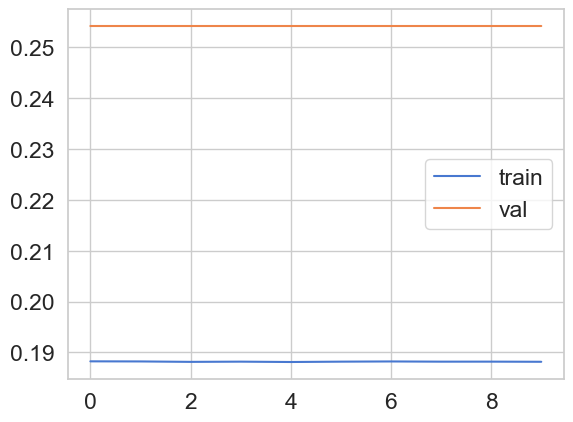

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

In [79]:
X_test_pred = model.model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

308/308 [==============================] - 9s 27ms/step


In [81]:
model.model.evaluate(X_test, y_test)

308/308 [==============================] - 9s 28ms/step - loss: 0.3679


0.3678623139858246

In [83]:
X_train_pred = model.model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])
train_mae_loss

1439/1439 [==============================] - 46s 32ms/step


ValueError: Shape of passed values is (46021, 3), indices imply (46021, 1)

In [84]:
sns.distplot(train_mae_loss, bins=50, kde=True)

NameError: name 'train_mae_loss' is not defined

In [332]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

C:\Users\hp\anaconda3\envs\ResParserV2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

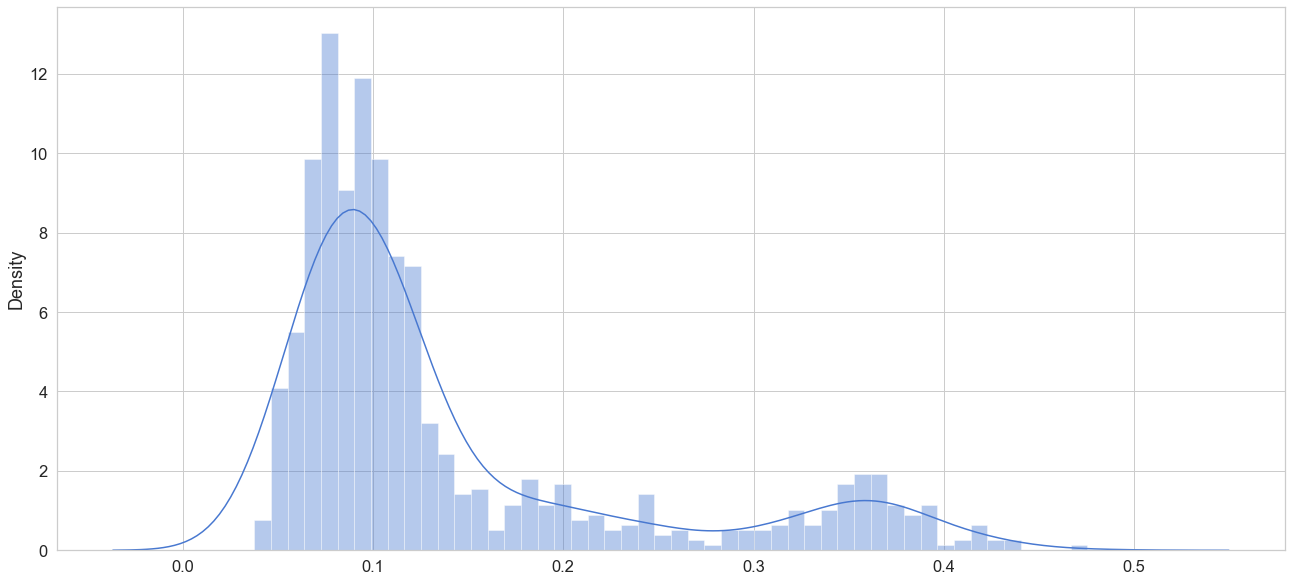

In [333]:
sns.distplot(test_mae_loss, bins=50, kde=True)

In [334]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[TIME_STEPS:].Close

In [335]:
test_score_df

loss  threshold  anomaly     Close
4528  0.107324       0.65    False  0.777214
621   0.102230       0.65    False  0.804876
5644  0.090089       0.65    False  0.781368
3990  0.087504       0.65    False  0.769520
5394  0.089899       0.65    False  0.793358
...        ...        ...      ...       ...
1336  0.424934       0.65    False  1.938586
4033  0.424660       0.65    False  2.002595
647   0.419340       0.65    False  1.910357
4382  0.417755       0.65    False  1.885575
5079  0.415680       0.65    False  1.778610

[893 rows x 4 columns]

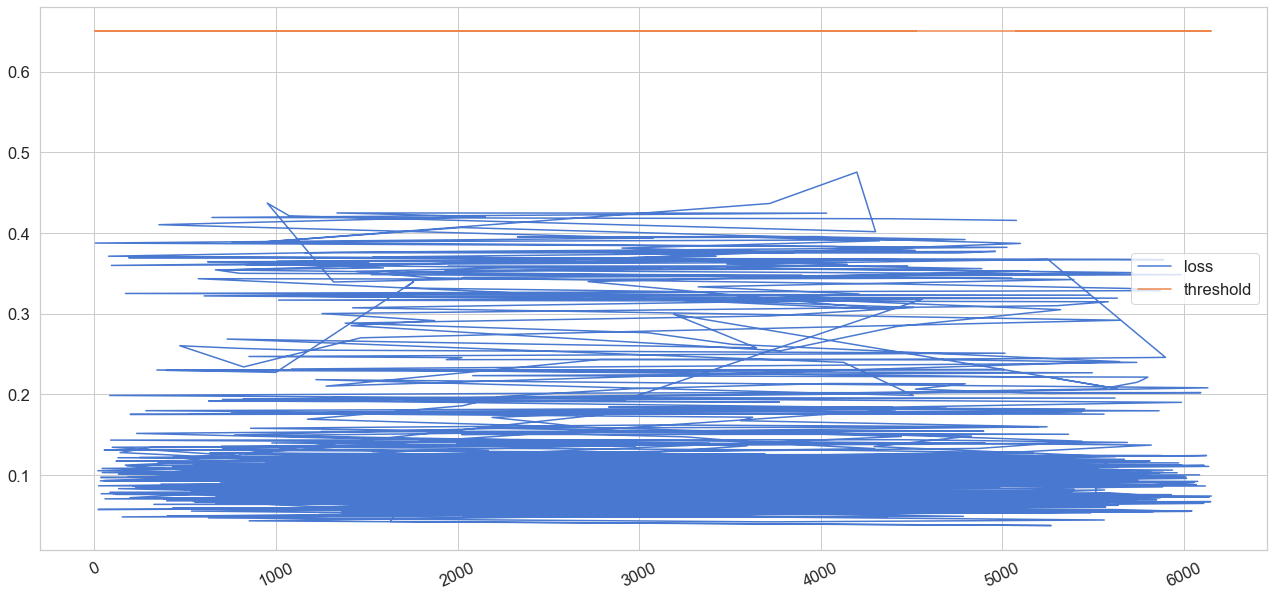

In [336]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()

## Task 8: Detect Anomalies in the Data

In [327]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

Empty DataFrame
Columns: [loss, threshold, anomaly, Close]
Index: []

In [340]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
)

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [108]:
df.isna().sum()

Close    119
dtype: int64

In [173]:
updated_df_drop = df.dropna(axis=0)

In [174]:
df['Imputed_Close']=df['Close'].fillna(df['Close'].mean())
df

Date     Close  Imputed_Close
2435 1997-10-07   12481.0        12481.0
2627 1997-10-08   12433.0        12433.0
3300 1997-10-09   12684.0        12684.0
4016 1997-10-10   12737.0        12737.0
2674 1997-10-13   12698.0        12698.0
...         ...       ...            ...
2427 2022-02-24  111592.0       111592.0
4111 2022-02-25  113142.0       113142.0
1973 2022-03-02  115174.0       115174.0
720  2022-03-03  115166.0       115166.0
24   2022-03-04  114474.0       114474.0

[6156 rows x 3 columns]

In [175]:
df.isna().sum()

Date               0
Close            119
Imputed_Close      0
dtype: int64

In [221]:
updated_df_drop.isna().sum()


Date            0
Close           0
Close_scaled    0
dtype: int64

In [320]:
train, test = updated_df_drop.loc[updated_df_drop['Date'] <= '2013-09-03'], updated_df_drop.loc[updated_df_drop['Date'] > '2013-09-03']
train.shape, test.shape

((3936, 3), (2101, 3))

In [291]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\hp\anaconda3\envs\Excell-Chatbot\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hp\anaconda3\envs\Excell-Chatbot\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [286]:
'''scaler = StandardScaler()
scaler = scaler.fit(updated_df_drop[['Close']])

updated_df_drop['Close_scaled'] = scaler.transform(updated_df_drop[['Close']])
# test['Close'] = scaler.transform(test[['Close']])'''

"scaler = StandardScaler()\nscaler = scaler.fit(updated_df_drop[['Close']])\n\nupdated_df_drop['Close_scaled'] = scaler.transform(updated_df_drop[['Close']])\n# test['Close'] = scaler.transform(test[['Close']])"

In [287]:
updated_df_drop

Date     Close  Close_scaled
2435 1997-10-07   12481.0     -1.210351
2627 1997-10-08   12433.0     -1.211918
3300 1997-10-09   12684.0     -1.203725
4016 1997-10-10   12737.0     -1.201995
2674 1997-10-13   12698.0     -1.203268
...         ...       ...           ...
2427 2022-02-24  111592.0      2.024626
4111 2022-02-25  113142.0      2.075218
1973 2022-03-02  115174.0      2.141543
720  2022-03-03  115166.0      2.141282
24   2022-03-04  114474.0      2.118695

[6037 rows x 3 columns]

In [288]:
df

Date     Close  Imputed_Close
2435 1997-10-07   12481.0        12481.0
2627 1997-10-08   12433.0        12433.0
3300 1997-10-09   12684.0        12684.0
4016 1997-10-10   12737.0        12737.0
2674 1997-10-13   12698.0        12698.0
...         ...       ...            ...
2427 2022-02-24  111592.0       111592.0
4111 2022-02-25  113142.0       113142.0
1973 2022-03-02  115174.0       115174.0
720  2022-03-03  115166.0       115166.0
24   2022-03-04  114474.0       114474.0

[6156 rows x 3 columns]

In [292]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

# X_train, y_train = create_sequences(updated_df_drop[['Close_scaled']], updated_df_drop['Close_scaled'])


X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (3906, 30, 1)
Testing shape: (2071, 30, 1)


In [209]:
'''# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X_train,y_train, train_size=0.7)

# Now since we want the valid and test size to be equal (15% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)'''

In [135]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((4279, 30, 1), (4279,)), ((894, 30, 1), (894,)), ((893, 30, 1), (893,)))

In [293]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))

model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_11 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [294]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.15,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
104/104 [==============================] - 12s 86ms/step - loss: 0.1905 - val_loss: 0.1693
Epoch 2/100
104/104 [==============================] - 8s 79ms/step - loss: 0.1313 - val_loss: 0.1061
Epoch 3/100
104/104 [==============================] - 7s 72ms/step - loss: 0.1133 - val_loss: 0.1017
Epoch 4/100
104/104 [==============================] - 8s 75ms/step - loss: 0.1157 - val_loss: 0.1667
Epoch 5/100
104/104 [==============================] - 8s 76ms/step - loss: 0.1033 - val_loss: 0.1058
Epoch 6/100
104/104 [==============================] - 8s 75ms/step - loss: 0.0946 - val_loss: 0.1687


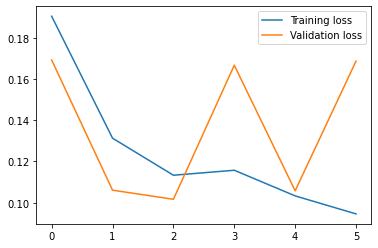

In [295]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [311]:
model.evaluate(X_test, y_test)

65/65 [==============================] - 2s 20ms/step - loss: 0.3421


0.34212854504585266

Reconstruction error threshold: 0.3924140129771651


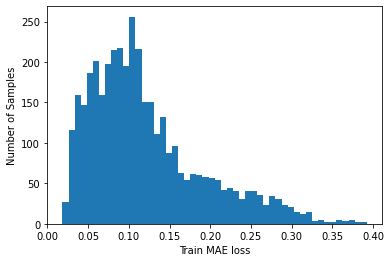

In [312]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

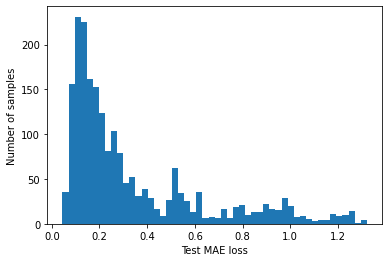

In [313]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [314]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [315]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(576, 6)

In [316]:
test_score_df['Close']

1569    0.987118
4924    0.958594
5374    0.959522
467     0.991942
5523    1.009706
          ...   
2427    3.566789
4111    3.638680
1973    3.732927
720     3.732556
24      3.700460
Name: Close, Length: 2071, dtype: float64

In [324]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close'].values.reshape(1, -1)), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(1, -1)), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
plt.savefig("anomaly.png", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>